In [30]:
import pandas as pd
import historic
from pathlib import Path
import cityRemap
from sklearn.utils import resample
import numpy as np
import scipy
import plotly.express as px
from scipy import stats
import seaborn as sns

In [31]:
historic_interval = pd.DataFrame()
historic_data = pd.read_csv('extracted/high/AMS.csv')
historic_data.dt = pd.DatetimeIndex(historic_data.dt)
historic_data = historic_data[(historic_data.dt.dt.year>2019-5) & (historic_data.dt.dt.year<2020)]

In [32]:
all = []
for hour in range(24):
    for month in range(1,13):
        sample = historic_data[(historic_data.dt.dt.month==month) & (historic_data.dt.dt.hour==hour)]
        pval = stats.shapiro(sample['Temperature'])[0]
        all.append(pval)

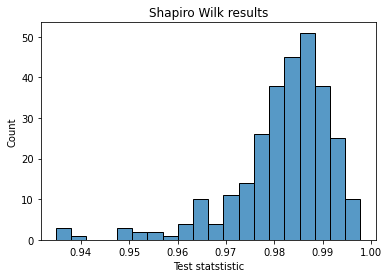

In [33]:
ax = sns.histplot(pd.DataFrame(all))
ax.set(xlabel='Test statstistic',title='Shapiro Wilk results')
plt.legend([],[], frameon=False)

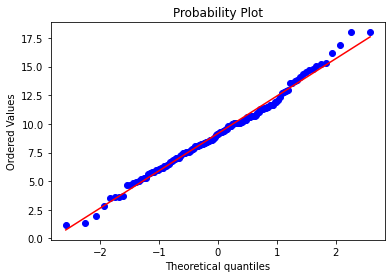

In [34]:
import statsmodels.api as sm
from matplotlib import pyplot as plt
sample = historic_data[(historic_data.dt.dt.month==2) & (historic_data.dt.dt.hour==12)]
ax1 = plt.subplot()
res = stats.probplot(sample['Temperature'], plot=plt)

In [35]:
testset = pd.read_csv(Path('extracted/high/AMS.csv'))
testset['dt'] = pd.DatetimeIndex(testset.dt)
testset = testset[testset['dt'].dt.year==2020]
testset = testset[['dt','Temperature']]

In [36]:
def get_optimal(conf):
    optimal = pd.DataFrame()
    for month in range(1,13):
        for hour in range(24):
            points = testset[(testset.dt.dt.month==month) & (testset.dt.dt.hour==hour)]
            upper = points['Temperature'].quantile(conf)
            lower = points['Temperature'].quantile(1-conf)
            optimal = optimal.append({'Lower':lower,'Higher':upper},ignore_index=True)
    return optimal

In [37]:
df = pd.DataFrame(
        {'dt': pd.date_range('2021-01-01', '2022-01-01', freq='1H', closed='left')})
date = pd.DataFrame()
for month in range(1,13):
    month_data = df[df.dt.dt.month==month]
    date = date.append(month_data.iloc[0:24],ignore_index=True)
date = pd.DatetimeIndex(date.dt)

In [38]:
def get_historical_boot(conf,year):    
    historic_interval = pd.DataFrame()
    historic_data = pd.read_csv('extracted/high/AMS.csv')
    historic_data.dt = pd.DatetimeIndex(historic_data.dt)
    historic_data = historic_data[(historic_data.dt.dt.year>2019-year) & (historic_data.dt.dt.year<2020)]
    for month in range(1,13):
        for hour in range(24):
                points = historic_data.loc[(historic_data.dt.dt.hour==hour) & (historic_data.dt.dt.month==month)]
                points = resample(points, replace=True, n_samples=50000, random_state=1)
                lower = points['Temperature'].quantile(1-conf)
                higher = points['Temperature'].quantile(conf)
                historic_interval = historic_interval.append({'Lower':lower,'Higher':higher}, ignore_index=True)
    return historic_interval

In [61]:
boot_intervals = get_historical_boot(0.95,5)

In [54]:
optimal = get_optimal(0.95)

In [63]:
boot_intervals['Hi optimal']=optimal['Higher']
boot_intervals['Lo optimal']=optimal['Lower']

In [64]:
boot_intervals = boot_intervals.rename(columns={'Hi':'Hi TBATS','lo':'Lo TBATS','Lower':'Lo bootstrap','Higher':'Hi bootstrap',})

In [66]:
fig = px.line(boot_intervals, y=['Hi bootstrap','Lo bootstrap','Hi optimal','Lo optimal'], x=cityRemap.date_index['Date'], labels={'value':"Temperature",'x':'Date'}, title='Bootstrap interval prediction',color_discrete_sequence=['blue','blue','green','green'])

fig.show()